# Open database

We open and merge all the files provided into one database.

In [2]:
import numpy as np
import pandas as pd
import missingno as msno
from scipy.interpolate import griddata
import multiprocess
from functools import partial
import datetime as dt

import os
os.chdir("F:/Defi_IA/data")

import warnings
warnings.filterwarnings('ignore')

from pyproj import Proj, transform
inProj = Proj(init='epsg:4326')
outProj = Proj(init='epsg:2154')

<AxesSubplot:>

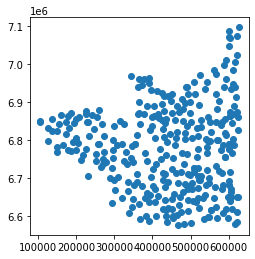

In [3]:
stations = pd.read_csv(
    "Other/stations_coordinates.csv",
    dtype = {"number_sta": int}         
).rename(
    columns={"number_sta": "station", "lat": "latitude", "lon": "longitude", "height_sta": "height"}
)
stations['coord_x'], stations['coord_y'] = transform(inProj, outProj, stations.longitude.to_numpy(), stations.latitude.to_numpy())

import geopandas as gpd
gdf_stations = gpd.GeoDataFrame(stations, crs=2154, geometry=gpd.points_from_xy(stations.coord_x, stations.coord_y, crs=2154))
gdf_stations.plot()

### Index Building

In [4]:
# Index for features and predictions
test_features_index = pd.read_csv("Test/X_station_test.csv")[['Id']]
test_features_index["station"] = test_features_index["Id"].str.split("_").str[0].astype(int)
test_features_index["day_index"] = test_features_index["Id"].str.split("_").str[1].astype(int)

df_day_index = pd.concat([
    pd.DataFrame({
        'day_index':list(range(2*365)),
        'test':False,
        'day':list(range(2*365))}),
    pd.DataFrame({
        'day_index':test_features_index[test_features_index.station==56137001].day_index.unique(), # Ne marche pas à creuser...
        'test':True,
        'day':list(range(363))}),
])

first_date = np.datetime64("2016-01-01T00:00")
df_date_index = pd.DataFrame({'date': [first_date + pd.Timedelta(days=i) for i in range(730)]})
df_date_index['day_index'] = range(730)
df_date_index['month'] = df_date_index.date.dt.month
df_date_index.drop(['date'], axis=1, inplace=True)

df_id_month_test = pd.read_csv("Test/X_station_test.csv").assign(day_index=lambda x: x.Id.str.split("_").str[1].astype(int))[['day_index', 'month']].drop_duplicates().reset_index(drop=True)
df_date_index = pd.concat([df_date_index.assign(test=False), df_id_month_test.assign(test=True)])

df_day_index = pd.merge(df_day_index, df_date_index, on=['test', 'day_index'])
df_day_index.to_csv("Dataset/Test/index_day.csv", index=False)

df_full_index_day = pd.merge(stations[['station']], df_day_index, how="cross")
df_full_index_day.sort_values(['station', 'test', 'day'], inplace=True)
df_full_index_day = df_full_index_day[['station', 'test', 'day', 'day_index', 'month']]

df_full_index = pd.merge(df_full_index_day, pd.DataFrame({'hour': range(24)}), how='cross')
df_full_index.sort_values(['station', 'test', 'day', 'hour'], inplace=True)
df_full_index = df_full_index[['station', 'test', 'day', 'hour', 'day_index', 'month']]

print(df_full_index.shape)
df_full_index.head()

(8525400, 6)


,station,test,day,hour,day_index,month
0,14047002,False,0,0,0,1
1,14047002,False,0,1,0,1
2,14047002,False,0,2,0,1
3,14047002,False,0,3,0,1
4,14047002,False,0,4,0,1


Save Index

In [32]:
df_full_index_day.to_csv("Dataset/Full_index_day.csv", index=False)
df_full_index.to_csv("Dataset/Full_index.csv", index=False)

### Load Y value:

In [5]:
#Train
#Ground
train_ground = pd.read_csv(
    "Train/Y_train.csv", 
    parse_dates=['date'], 
    infer_datetime_format=True,
    dtype = {"number_sta": int, "Ground_truth": float},
).rename(columns = {"Ground_truth": "y", "Id": "id"})[['id', 'y']]

#Observation
train_observation = pd.read_csv(
    "Train/Baselines/Baseline_observation_train.csv",
    dtype = {"Prediction": float}
).assign(test=True).rename(columns = {"Prediction": "Observation", "Id": "id"})[['id', 'Observation']]

#Forecast
train_forecast = pd.read_csv(
    "Train/Baselines/Baseline_forecast_train.csv",
    dtype = {"Prediction": float}
).assign(test=True).rename(columns = {"Prediction": "Forecast", "Id": "id"})[['id', 'Forecast']]

train = pd.merge(train_ground, train_observation, on='id', how='outer')
train = pd.merge(train, train_forecast, on='id', how='outer')
train["station"] = train["id"].str.split("_").str[0].astype(int)
train["day_index"] = train["id"].str.split("_").str[1].astype(int)

#Test
#Observation
test_observation = pd.read_csv(
    "Test/Baselines/Baseline_observation_test.csv",
    dtype = {"Prediction": float}
).rename(columns = {"Prediction": "Observation", "Id": "id"})[['id', 'Observation']]

#Forecast
test_forecast = pd.read_csv(
    "Test/Baselines/Baseline_forecast_test.csv",
    dtype = {"Prediction": float}
).rename(columns = {"Prediction": "Forecast", "Id": "id"})[['id', 'Forecast']]

test = pd.merge(test_observation, test_forecast, on='id', how='outer')
test["station"] = test["id"].str.split("_").str[0].astype(int)
test["day_index"] = test["id"].str.split("_").str[1].astype(int)
test['y'] = np.nan

In [6]:
predictions = pd.merge(
    df_full_index_day,
    pd.concat([train.assign(test=False), test.assign(test=True)], axis = "rows"),
    on = ['station', 'test', 'day_index'],
    how = "left",
)
predictions = predictions.drop("id", axis=1).sort_values(['station', 'test', 'day']).reset_index(drop=True)
predictions.to_csv("Dataset/predictions.csv", index=False)
predictions.head()

,station,test,day,day_index,month,y,Observation,Forecast
0,14047002,False,0,0,1,NaN,NaN,8.410274
1,14047002,False,1,1,1,NaN,NaN,12.642678
2,14047002,False,2,2,1,NaN,NaN,5.331558
3,14047002,False,3,3,1,NaN,NaN,3.967951
4,14047002,False,4,4,1,NaN,NaN,3.360032


### Load X Features Values

In [7]:
features_mesured = ['ff', 't', 'td', 'hu', 'dd', 'precip']

#Train
train_features = pd.read_csv(
    "Train/X_station_train.csv", 
    parse_dates=['date'], 
    infer_datetime_format=True,
    dtype = {"number_sta": int},
).rename(
    columns = {"number_sta": "station", "Id": "id"}
).assign(test=False)

train_features["day_index"] = train_features["id"].str.split("_").str[1].astype(int)
train_features["hour"] = train_features["id"].str.split("_").str[2].astype(int)
train_features.drop(["date", "id"], axis=1, inplace=True)

#Test
test_features = pd.read_csv(
    "Test/X_station_test.csv",
).rename(
    columns = {"Id": "id"}
).assign(test=True)

test_features["station"] = test_features["id"].str.split("_").str[0].astype(int)
test_features["day_index"] = test_features["id"].str.split("_").str[1].astype(int)
test_features["hour"] = test_features["id"].str.split("_").str[2].astype(int)

test_features.drop(["id", "month"], axis=1, inplace=True)
test_features.head()

,dd,hu,td,t,ff,precip,test,station,day_index,hour
0,NaN,NaN,NaN,278.35,NaN,NaN,True,14047002,277,4
1,NaN,NaN,NaN,278.40,NaN,0.0,True,14047002,277,5
2,NaN,NaN,NaN,279.01,NaN,0.0,True,14047002,277,6
3,NaN,NaN,NaN,279.66,NaN,0.0,True,14047002,277,7
4,NaN,NaN,NaN,279.99,NaN,0.0,True,14047002,277,8


In [8]:
#Final features
features = pd.merge(
    df_full_index,
    pd.concat([train_features, test_features], axis = "rows"),
    on=['station', 'test', 'day_index', 'hour'],
    how='left')

features = features.sort_values(['station', 'test', 'day', 'hour']).reset_index(drop=True)
features.to_csv("Dataset/features.csv", index=False)
features.head()

,station,test,day,hour,day_index,month,ff,t,td,hu,dd,precip
0,14047002,False,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN
1,14047002,False,0,1,0,1,NaN,NaN,NaN,NaN,NaN,NaN
2,14047002,False,0,2,0,1,NaN,NaN,NaN,NaN,NaN,NaN
3,14047002,False,0,3,0,1,NaN,NaN,NaN,NaN,NaN,NaN
4,14047002,False,0,4,0,1,NaN,NaN,NaN,NaN,NaN,NaN


### Temporal Interpolation

Features

In [9]:
def time_interpolate(x, features):
    for feature in features:
        if x[feature].isna().mean() < 0.80:
            x[feature] = x[feature].interpolate(limit=24) #24
    return x

features_time_interpolate_train = features[~features.test].groupby(['station']).apply(time_interpolate, features_mesured)

# Pas d'interpolation temporelle pour les test car les jours ne sont pas ordonés
features_time_interpolate_test = features[features.test] #.groupby(['station']).apply(time_interpolate, features_mesured)

features_time_interpolate = pd.concat([features_time_interpolate_train, features_time_interpolate_test])

features_time_interpolate[['station', 'test', 'day', 'hour', 'day_index', 'month'] + features_mesured].to_csv('Dataset/features_time_interpolate.csv', index=False)

features_time_interpolate.head()

,station,test,day,hour,day_index,month,ff,t,td,hu,dd,precip
0,14047002,False,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN
1,14047002,False,0,1,0,1,NaN,NaN,NaN,NaN,NaN,NaN
2,14047002,False,0,2,0,1,NaN,NaN,NaN,NaN,NaN,NaN
3,14047002,False,0,3,0,1,NaN,NaN,NaN,NaN,NaN,NaN
4,14047002,False,0,4,0,1,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:xlabel='test,day,hour'>

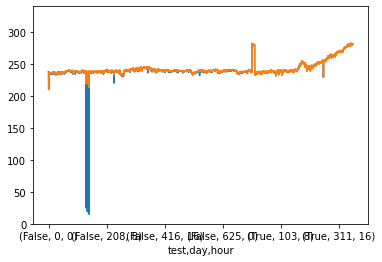

In [38]:
features.groupby(['test', 'day', 'hour']).t.agg(lambda x: (~x.isna()).sum()).plot(ylim=(0,340))
features_time_interpolate.groupby(['test', 'day', 'hour']).t.agg(lambda x: (~x.isna()).sum()).plot(ylim=(0,340))

In [39]:
data = features.groupby(['test', 'day', 'hour']).t.agg(lambda x: (~x.isna()).sum())
data[data<100]

test   day  hour
False  135  4       25
            5       26
            6       56
            7       62
       139  9       19
            10      21
            11      21
            12      50
       144  6       69
            10      15
            11      17
            12      34
Name: t, dtype: int64

Predictions

In [10]:
list_y_var = ['y', 'Observation', 'Forecast']

def time_interpolate(x, features):
    for feature in features:
        if x[feature].isna().mean() < 0.80: #0.80
            x[feature] = x[feature].interpolate(limit=5)
    return x

predictions_time_interpolate_train = predictions[~predictions.test].groupby(['station']).apply(time_interpolate, list_y_var)

# Pas d'interpolation temporelle pour les test car les jours ne sont pas ordonés
predictions_time_interpolate_test = predictions[predictions.test] #.groupby(['station']).apply(time_interpolate, list_y_var)

predictions_time_interpolate = pd.concat([predictions_time_interpolate_train, predictions_time_interpolate_test])

predictions_time_interpolate[['station', 'test', 'day', 'day_index', 'month'] + list_y_var].to_csv('Dataset/predictions_time_interpolate.csv', index=False)

def y_na(x):
    return np.round(x.isna().mean()*100, 2)

print(f"Y NA (train) : {y_na(predictions[~predictions.test].y)}% -> {y_na(predictions_time_interpolate[~predictions_time_interpolate.test].y)}%.")
print(f"Observation NA : {y_na(predictions.Observation)}% -> {y_na(predictions_time_interpolate.Observation)}%.")
print(f"Forecast NA : {y_na(predictions.Forecast)}% -> {y_na(predictions_time_interpolate.Forecast)}%.")
predictions_time_interpolate.head()

Y NA (train) : 31.67% -> 31.1%.
Observation NA : 30.47% -> 30.05%.
Forecast NA : 5.31% -> 4.03%.


,station,test,day,day_index,month,y,Observation,Forecast
0,14047002,False,0,0,1,NaN,NaN,8.410274
1,14047002,False,1,1,1,NaN,NaN,12.642678
2,14047002,False,2,2,1,NaN,NaN,5.331558
3,14047002,False,3,3,1,NaN,NaN,3.967951
4,14047002,False,4,4,1,NaN,NaN,3.360032


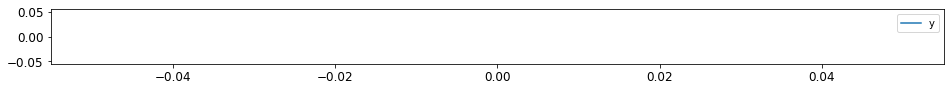

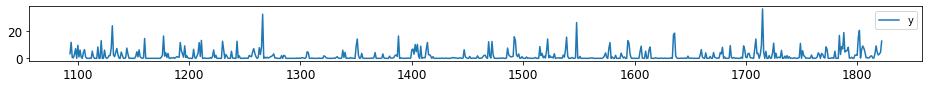

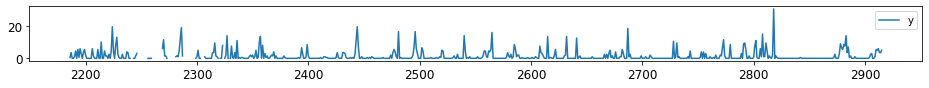

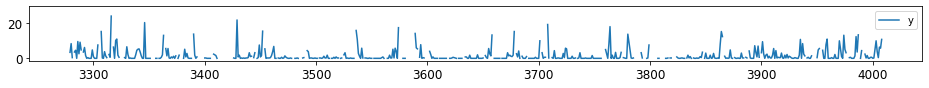

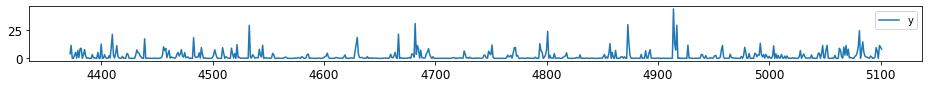

In [41]:
for i, (index, df_iter) in enumerate(predictions_time_interpolate[~predictions_time_interpolate.test].groupby('station')):
    df_iter[['y']].plot(subplots=True, fontsize=12, figsize=(16, 1))
    if i>3:
        break

<AxesSubplot:xlabel='test,day'>

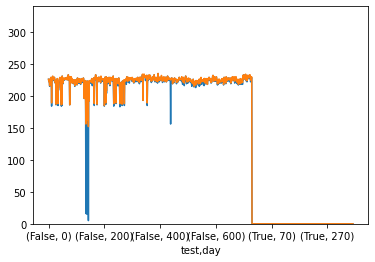

In [42]:
predictions.groupby(['test', 'day']).y.agg(lambda x: (~x.isna()).sum()).plot(ylim=(0,340))
predictions_time_interpolate.groupby(['test', 'day']).y.agg(lambda x: (~x.isna()).sum()).plot(ylim=(0,340))

### Spatial Interpolation

Need a minimum of points for each interpolation (4 points). So time interpoolation is necessary.

In [36]:
df_features_coord = pd.merge(features_time_interpolate, stations, on='station')
df_features_coord.drop(['longitude', 'latitude', 'height'], axis=1, inplace=True)

df_features_interpolate = df_full_index.copy()
for feature in features_mesured:
    reference_values = df_features_coord[~df_features_coord[feature].isna()]

    def agg_interpolate(key, df_points, feature):
        from scipy.interpolate import griddata
        from scipy.spatial.distance import cdist
        # A function that realize the interpolation of the model and with the staion coordinate
        index, group = key
        df_out = df_points[['station', 'coord_x', 'coord_y']].copy()
        df_out[feature] = griddata((group.coord_x, group.coord_y), group[feature], (df_out.coord_x, df_out.coord_y), method='cubic')

        # Nearest Neighboor in case of null value
        df_out.loc[df_out[feature].isna(), feature] = griddata((group.coord_x, group.coord_y), group[feature], (df_out[df_out[feature].isna()].coord_x, df_out[df_out[feature].isna()].coord_y), method='nearest')

        # Minimum distance
        df_out[f'dist_{feature}'] = cdist(df_out[['coord_x', 'coord_y']], group[~group[feature].isna()][['coord_x', 'coord_y']]).min(axis=1)
        return df_out.assign(test=index[0], day_index=index[1], hour=index[2]).drop(['coord_x', 'coord_y'], axis=1)

    with multiprocess.Pool(processes=12) as p:
        df_buffer=pd.concat(p.map(partial(agg_interpolate, df_points=stations, feature=feature), reference_values.groupby(['test', 'day_index', 'hour'])))

    #df_buffer=pd.concat([agg_interpolate(key, stations, feature) for key in reference_values.groupby(['test', 'day_index', 'hour'])])
    df_features_interpolate = pd.merge(df_features_interpolate, df_buffer, on=['station', 'test', 'day_index', 'hour'], how='outer')

    print(f'Feature {feature} finished.')

df_features_interpolate.head()

Feature ff finished.
Feature t finished.
Feature td finished.
Feature hu finished.
Feature dd finished.
Feature precip finished.


,station,test,day,hour,day_index,month,ff,dist_ff,t,dist_t,td,dist_td,hu,dist_hu,dd,dist_dd,precip,dist_precip
0,14047002,False,0,0,0,1,4.056472,9351.532478,279.406394,10785.923995,279.452594,10785.923995,101.051266,10785.923995,208.985256,9351.532478,-0.000035,10785.923995
1,14047002,False,0,1,0,1,4.171511,9351.532478,276.540162,10785.923995,276.594094,10785.923995,100.875933,10785.923995,219.652121,9351.532478,0.000010,10785.923995
2,14047002,False,0,2,0,1,3.813644,9351.532478,274.045721,10785.923995,274.260788,10785.923995,101.680669,10785.923995,210.558382,9351.532478,0.008242,10785.923995
3,14047002,False,0,3,0,1,3.631034,9351.532478,272.483210,10785.923995,272.618118,10785.923995,100.645315,10785.923995,199.090037,9351.532478,0.029730,10785.923995
4,14047002,False,0,4,0,1,2.231741,9351.532478,272.934190,10785.923995,272.829550,10785.923995,99.381360,10785.923995,179.928121,9351.532478,0.000002,10785.923995


In [53]:
df_features_interpolate.dist_ff.mean()

9039.86466722811

In [51]:
df_features_interpolate.dist_ff.std()

9796.010378943078

In [68]:
new_features = pd.merge(df_full_index[['station', 'test', 'day_index', 'hour']], df_features_interpolate, on=['station', 'test', 'day_index', 'hour'], how='left')
new_features = new_features.sort_values(['station', 'test', 'day_index', 'hour']).reset_index(drop=True)

features_time_interpolate.sort_values(['station', 'test', 'day_index', 'hour'], inplace=True)

dist_max_interpolate = 10000
for feature in features_mesured:
    condition = (new_features[f'dist_{feature}'] < dist_max_interpolate) | new_features.test
    new_features[feature] = np.where(condition, new_features[feature], features_time_interpolate[feature])
    new_features[feature] = np.where(new_features[feature] < 0, 0, new_features[feature]) #For precip feature

dist_columns = [f'dist_{feature}' for feature in features_mesured]
new_features['nearest_station'] = new_features[dist_columns].min(axis=1)
new_features.drop(dist_columns, axis=1, inplace=True)
new_features = new_features[['station', 'test', 'day', 'hour', 'day_index', 'month'] + features_mesured]

for feature in features_mesured:
    print(f"Y NA (train) : {y_na(features_time_interpolate[~features_time_interpolate.test][feature])}% -> {y_na(new_features[~new_features.test][feature])}%.")

new_features.to_csv('Dataset/features_interpolate_full.csv', index=False)
new_features.head()

Y NA (train) : 53.22% -> 44.81%.
Y NA (train) : 26.51% -> 17.11%.
Y NA (train) : 47.56% -> 39.04%.
Y NA (train) : 47.51% -> 38.99%.
Y NA (train) : 53.25% -> 44.84%.
Y NA (train) : 27.74% -> 17.78%.


,station,test,day,hour,day_index,month,ff,t,td,hu,dd,precip
0,14047002,False,0,0,0,1,4.056472,NaN,NaN,NaN,208.985256,NaN
1,14047002,False,0,1,0,1,4.171511,NaN,NaN,NaN,219.652121,NaN
2,14047002,False,0,2,0,1,3.813644,NaN,NaN,NaN,210.558382,NaN
3,14047002,False,0,3,0,1,3.631034,NaN,NaN,NaN,199.090037,NaN
4,14047002,False,0,4,0,1,2.231741,NaN,NaN,NaN,179.928121,NaN


Predictions

In [43]:
df_predictions_coord = pd.merge(predictions_time_interpolate, stations, on='station')
df_predictions_coord.drop(['longitude', 'latitude', 'height'], axis=1, inplace=True)

df_predictions_interpolate = df_full_index_day.copy()

list_y_var = ['y', 'Observation', 'Forecast']

for feature in list_y_var:
    reference_values = df_predictions_coord[~df_predictions_coord[feature].isna()]

    def agg_interpolate(key, df_points, feature):
        from scipy.interpolate import griddata
        from scipy.spatial.distance import cdist
        # A function that realize the interpolation of the model and with the staion coordinate
        index, group = key
        df_out = df_points[['station', 'coord_x', 'coord_y']].copy()
        df_out[feature] = griddata((group.coord_x, group.coord_y), group[feature], (df_out.coord_x, df_out.coord_y), method='cubic')

        # Nearest Neighboor in case of null value
        df_out.loc[df_out[feature].isna(), feature] = griddata((group.coord_x, group.coord_y), group[feature], (df_out[df_out[feature].isna()].coord_x, df_out[df_out[feature].isna()].coord_y), method='nearest')
        
        df_out[f'dist_{feature}'] = cdist(df_out[['coord_x', 'coord_y']], group[~group[feature].isna()][['coord_x', 'coord_y']]).min(axis=1)
        return df_out.assign(test=index[0], day_index=index[1]).drop(['coord_x', 'coord_y'], axis=1)

    df_buffer = pd.concat([agg_interpolate(key, stations, feature) for key in reference_values.groupby(['test', 'day_index'])])
    df_predictions_interpolate = pd.merge(df_predictions_interpolate, df_buffer, on=['station', 'test', 'day_index'], how='outer')

    print(f'Feature {feature} finished.')

df_predictions_interpolate.head()

Feature y finished.
Feature Observation finished.
Feature Forecast finished.


,station,test,day,day_index,month,y,dist_y,Observation,dist_Observation,Forecast,dist_Forecast
0,14047002,False,0,0,1,11.939015,10785.923995,0.059930,10785.923995,8.410274,0.0
1,14047002,False,1,1,1,13.510043,10785.923995,11.939015,10785.923995,12.642678,0.0
2,14047002,False,2,2,1,3.215059,10785.923995,13.510043,10785.923995,5.331558,0.0
3,14047002,False,3,3,1,2.427259,10785.923995,3.215059,10785.923995,3.967951,0.0
4,14047002,False,4,4,1,4.322350,10785.923995,2.427259,10785.923995,3.360032,0.0


In [49]:
df_predictions_interpolate.dist_y.mean()

4142.385196833318

In [69]:
new_predictions = pd.merge(df_full_index_day[['station', 'test', 'day_index']], df_predictions_interpolate, on=['station', 'test', 'day_index'], how='left')
new_predictions = new_predictions.sort_values(['station', 'test', 'day_index']).reset_index(drop=True)

predictions_time_interpolate.sort_values(['station', 'test', 'day_index'], inplace=True)
#new_predictions = predictions_time_interpolate.sort_values(['station', 'test', 'day']).copy()

dist_max_interpolate = 10000
for feature in list_y_var:
    condition = (new_predictions[f'dist_{feature}'] < dist_max_interpolate) | new_predictions.test
    new_predictions[feature] = np.where(condition, new_predictions[feature], predictions_time_interpolate[feature])
    new_predictions[feature] = np.where(new_predictions[feature] < 0, 0, new_predictions[feature]) #For precip feature

dist_columns = [f'dist_{feature}' for feature in list_y_var]
new_predictions['nearest_station'] = new_predictions[dist_columns].min(axis=1)
new_predictions.drop(dist_columns, axis=1, inplace=True)
new_predictions = new_predictions[['station', 'test', 'day', 'day_index', 'month'] + list_y_var]
new_predictions.to_csv('Dataset/predictions_interpolate_full.csv', index=False)

def y_na(x):
    return np.round(x.isna().mean()*100, 2)

print(f"Y NA (train) : {y_na(predictions_time_interpolate[~predictions_time_interpolate.test].y)}% -> {y_na(new_predictions[~new_predictions.test].y)}%.")
print(f"Observation NA : {y_na(predictions_time_interpolate.Observation)}% -> {y_na(new_predictions.Observation)}%.")
print(f"Forecast NA : {y_na(predictions_time_interpolate.Forecast)}% -> {y_na(new_predictions.Forecast)}%.")

new_predictions.head()

Y NA (train) : 31.1% -> 21.35%.
Observation NA : 30.05% -> 14.31%.
Forecast NA : 4.03% -> 4.03%.


,station,test,day,day_index,month,y,Observation,Forecast
0,14047002,False,0,0,1,NaN,NaN,8.410274
1,14047002,False,1,1,1,NaN,NaN,12.642678
2,14047002,False,2,2,1,NaN,NaN,5.331558
3,14047002,False,3,3,1,NaN,NaN,3.967951
4,14047002,False,4,4,1,NaN,NaN,3.360032


### Results Analysis

<AxesSubplot:xlabel='test,day,hour'>

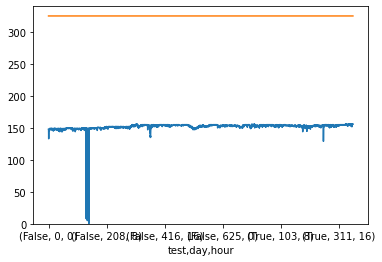

In [47]:
features.groupby(['test', 'day', 'hour']).ff.agg(lambda x: (~x.isna()).sum()).plot(ylim=(0,340))
new_features.groupby(['test', 'day', 'hour']).ff.agg(lambda x: (~x.isna()).sum()).plot(ylim=(0,340))

<AxesSubplot:>

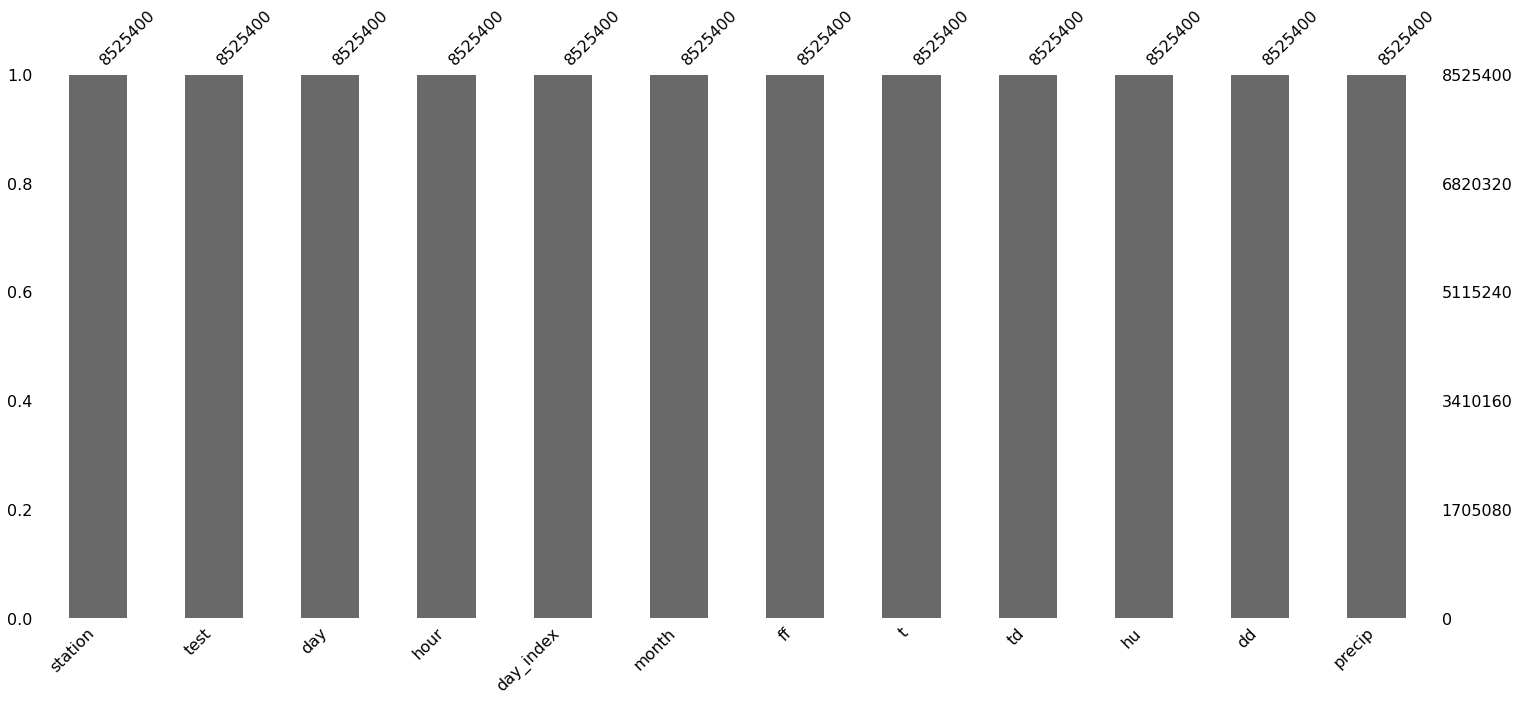

In [48]:
msno.bar(new_features)

<AxesSubplot:>

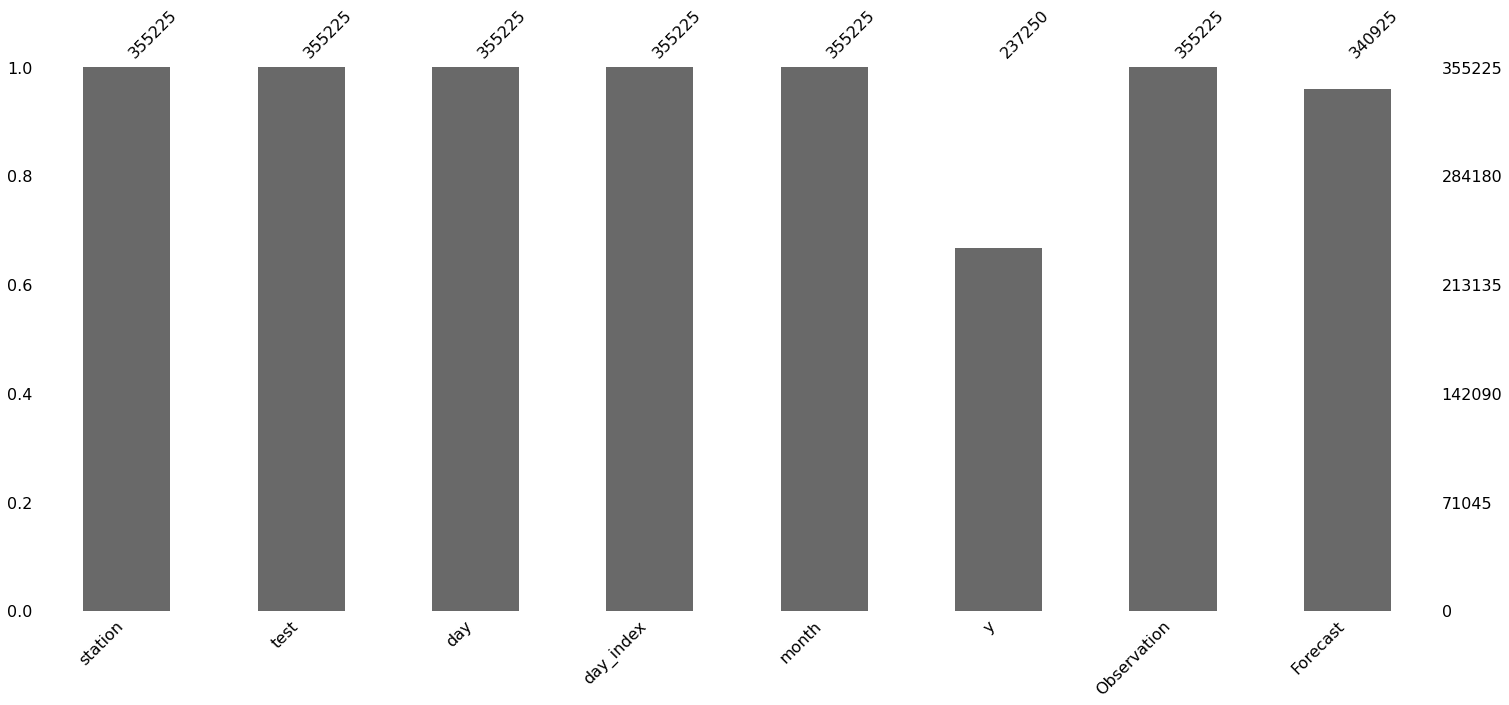

In [49]:
msno.bar(new_predictions)

### Agregation

In [50]:
def make_agg(x, on, by, how):
    """Function to make aggregates easilly.
    
    Parameters
    ----------
        x (pd.DataFrame): Features dataframe.
        on (list): List of targets aggregates.
        by (list): List of columns we will use to group data.
        how (list): List of statistics.
    
    """
    columns = []
    for col in on:
        for stat in how:
            columns.append(f"{stat}_{col}") #_by_{'_'.join(by)}")
    x = x.groupby(by)[on].agg(how)  
    x.columns = columns
    return x

In [51]:
features_agg = make_agg(
    x = new_features,
    on = features_mesured, 
    by = ["test", "station", "day"],
    how = ["mean"]
).reset_index()

df = pd.merge(
    left = new_predictions,
    right = features_agg,
    on = ["test", "station", "day"],
    how = "left",
)

df.sort_values(['station', 'test', 'day'], inplace=True)
df.to_csv("Dataset/weather_full.csv", index=False)